In [101]:
# Importo librerie
import numpy as np
import pandas as pd
import matplotlib as mpl
import htmlGrabber
import os, json, re
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from bs4 import BeautifulSoup

In [182]:
# Organizzo working-directory
for dir in ['data/raw', 'data/tmp', 'data/final', 'images']: 
    os.makedirs(dir, exist_ok=True)

# Carico variabili d'ambiente
load_dotenv(override=True)
BASEURL = os.getenv('BASEURL')
LASTPAGE = int(os.getenv('LASTPAGE'))

## Web scraping

In [90]:
# Salvo html
G = htmlGrabber.Grabber()
G.buildUrl(baseUrl=BASEURL, pageNumbers=LASTPAGE)
G.run()
# G.exportHtml(filename='data/raw/htmlContents.json')

Output()

In [91]:
# Scraping
htmls = G.htmls
rawData = []
for html in htmls.values():
    soup = BeautifulSoup(html, 'html.parser')
    for li in soup.find_all('li'):
        brand = li.get('data-vendor')
        item = li.get('data-alpha')
        add_info = li.get('data-handle')
        price = li.select_one('h4.price')
        if pd.isna([brand, item, add_info, price]).sum() == 4:
            continue
        tmpData = {
            'brand': brand,
            'item': item,
            'add-info': add_info,
            'price': price.text if price else np.nan
        }
        rawData.append(tmpData)

## Data cleaning

In [92]:
rawdf = pd.DataFrame(rawData)
df = rawdf.copy()
df.head()

,brand,item,add-info,price
0,obey,BLAK 10 YEAR ANNIVERSARY HOODY,obey-felpa-blak-10-year-anniversary-hoody-blk,€45.00
1,obey,BLAK 10 YEAR ANNIVERSARY TEE,obey-maglietta-blak-10-year-anniversary-tee-blk,€20.00
2,huf,HUF MILANO S/S TEE BLACK,huf-t-shirt-huf-milano-s-s-tee-black-71120mc00...,€20.00
3,hurley,MAX 4 3 FULLSUIT,hurley-max-4-3-fullsuit-black,€200.00
4,edwin,PRIVATE LETTER SHORT,edwin-pantalone-corto-private-letter-short-0d2-67,€55.00


In [93]:
#
df['Brand'] = df['brand'].str.upper()
df['Item'] = df['item'].str.lower()

# Cleaning: Price 
df['Price'] = (df['price'].str.replace('€', '')).astype(np.float64)

# Create: Category
df['Category'] = pd.Series([np.nan]*df.shape[0], dtype=object)

In [94]:
# Create category - a causa dell'item con pochi dettagli non è stato possibile recuperare tutte le categorie di abbigliamento.
categoryRules = {
    'felpe': ['fleece', 'hoodie', 'sweater', 'hoody', 'hood', 'sweat', 'felp[ae]'],
    'giacche': ['jacket', 'bomber'],
    'gilet': ['cardigan', 'gilet'],
    'maglie': ['tee', 't shirt', 'knit', 'top', 'fullsuit', 'magliett[ae]'],
    'pantaloni': ['pant', 'trousers', 'jean', 'jeans'],
    'shorts': ['short'],
    'camicie': ['shirt', 'camicia'],
    'moda mare': []
}
for index, row in enumerate(df['add-info']):
    for category, rules in categoryRules.items():
        for rule in rules:
            if re.search(rule, row):
                df.loc[index, 'Category'] = category
mask = df['Category'].isna()
df.loc[mask, 'add-info'].value_counts(dropna=False).to_csv('data/tmp/itemUnclassified.csv')

In [95]:
# Final dataframe
df = df[['Brand', 'Item', 'Category', 'Price']]
df.to_csv('data/final/collectionsData.csv', index=False)

## Data analysis

### Dataset structure

In [199]:
df = pd.read_csv('data/final/collectionsData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Brand     1266 non-null   object 
 1   Item      1266 non-null   object 
 2   Category  1077 non-null   object 
 3   Price     1266 non-null   float64
dtypes: float64(1), object(3)
memory usage: 39.7+ KB


In [231]:
nan = pd.DataFrame(df.isna().sum(), columns=['nan'])
nan['values'] = df.notna().sum()
nan['total'] = nan['nan']+nan['values']
nan['nan%'] = (nan['nan']/nan['total']).round(3)
nan = nan.reset_index()
nan

,index,nan,values,total,nan%
0,Brand,0,1266,1266,0.000
1,Item,0,1266,1266,0.000
2,Category,189,1077,1266,0.149
3,Price,0,1266,1266,0.000


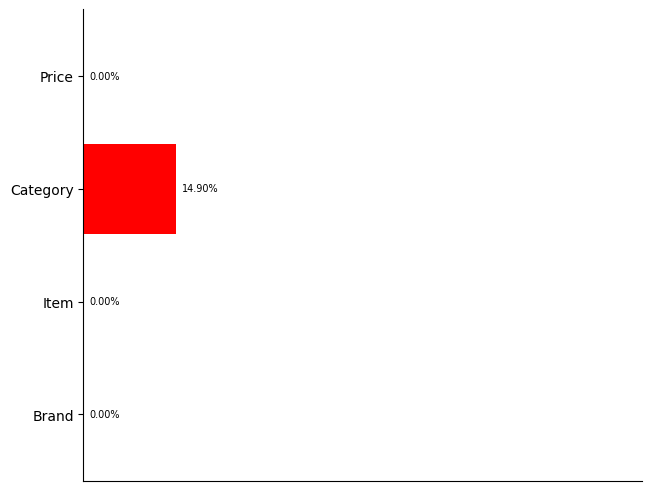

In [285]:
fig, ax = plt.subplots(layout='constrained')
ax.barh(nan.index, nan['nan%'], color='red')
ax.set_yticks(nan.index, nan['index'])
ax.set_xticks(np.arange(0, 1, 0.1))
ax.tick_params(axis='x', bottom=False, labelbottom=False)

for orientation, spine in ax.spines.items():
    if orientation not in ['left', 'bottom']:
        spine.set_visible(False)

for index, perc in enumerate(nan['nan%']):
    ax.annotate(f'{perc:.2%}', (perc+0.01, index), va='center', ha='left', fontsize=7)
fig.savefig('images/nan.png', dpi=300)
plt.show()

### Univariate analysis

#### Brand

In [209]:
def paretoAnalysis(dataframe:pd.DataFrame, column:str, dropna:bool=False, threshold:float=0.8, otherClass:str='OTH', otherClassColor=None, filename:str=None):
    df = dataframe[column].value_counts(dropna=dropna).to_frame().reset_index()
    df['freq'] = (df['count']/df['count'].sum()).round(3)
    df['cumfreq'] = df['freq'].cumsum().round(3)
    df['pareto'] = [1 if cumfreq <= threshold else 0 for cumfreq in df['cumfreq']]
    paretoMask = df['pareto']==1
    notParetoMask = ~paretoMask

    paretoDf = df[paretoMask]
    paretoOtherDf = pd.DataFrame([{
        column: otherClass,
        'count': df.loc[notParetoMask, 'count'].sum(),
        'freq': df.loc[notParetoMask, 'freq'].sum(),
        'cumfreq': df.loc[notParetoMask, 'freq'].sum(),
        'pareto': 0
    }])
    paretoDf = pd.concat([paretoDf, paretoOtherDf], ignore_index=True)

    cmap = mpl.colormaps['Paired']
    paretoDfColors = {d: cmap(i) for i, d in enumerate(paretoDf[column])}
    if otherClassColor:
        paretoDfColors[otherClass] = otherClassColor

    dfColors = {d: paretoDfColors.get(d, paretoDfColors[otherClass]) for d in df[column]}
    fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(10, 5))
    ax[0].bar(df.index, df['count'], color=dfColors.values())
    ax[0].set_xticks(df.index, df[column], rotation=75)
    ax[0].set_yticks([])
    ax[1].pie(paretoDf['freq'], labels=paretoDf[column], colors=paretoDfColors.values(), autopct='%1.1f%%', 
            textprops=dict(fontsize=7))

    for spine in ax[0].spines.values():
        spine.set_visible(False)

    for index, count in enumerate(df['count']):
        ax[0].annotate(f'{count}', (index, count+4), ha='center', fontsize=7)

    if filename:
        fig.savefig(filename, dpi=300)

    return df, paretoDf

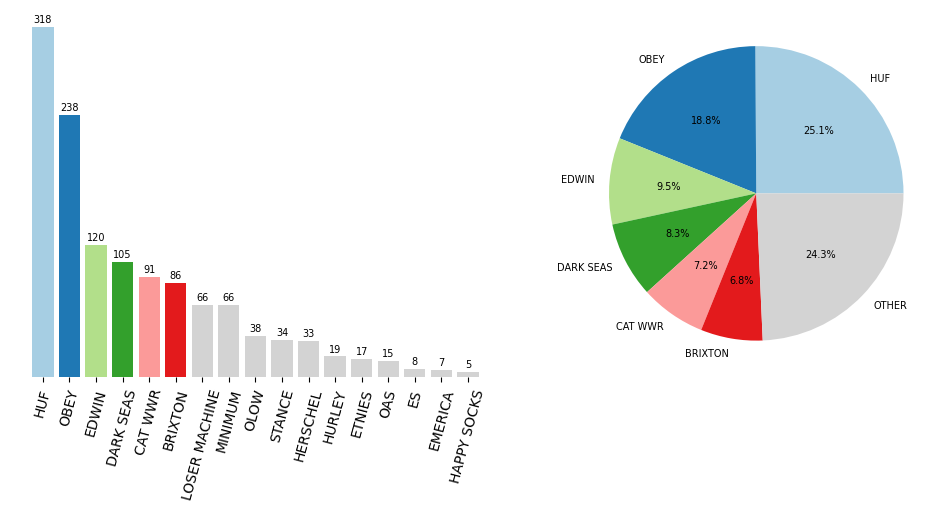

In [213]:
brand, paretoBrand = paretoAnalysis(df, 'Brand', dropna=True, otherClass='OTHER', otherClassColor='lightgrey', filename='images/brand.png')

i 1266 prodotti presenti nel sito web sono solamente di 12 brand. In particolare, l'80% degli articoli appartiene a 7 brand, ovvero:
1. HUF
2. OBEY
3. EDWIN
4. DARK SEAS
5. CAT WWR
6. BRIXTON
7. LOSER MACHINE

#### Category

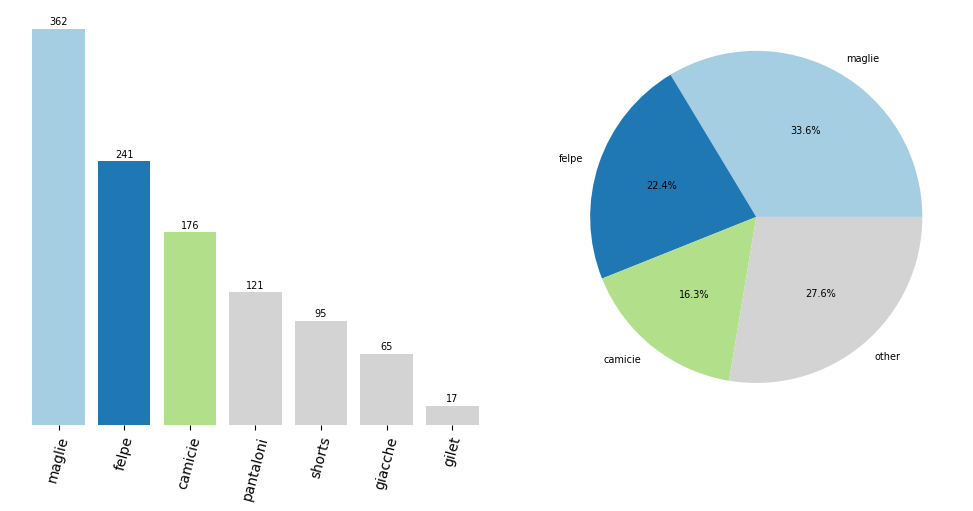

In [214]:
brand, paretoBrand = paretoAnalysis(df, 'Category', dropna=True, otherClass='other', otherClassColor='lightgrey', filename='images/category.png')

## Bivariate Analysis

In [53]:
def cv_inter(row):
    if row <= 0.2:
        v = 'bassa'
    elif (row > 0.2)and(row <= 0.4):
        v = 'moderata'
    elif (row > 0.4)and(row <= 0.6):
        v = 'alta'
    else:
        v = 'molto alta'
    return v

brandPrice = df.groupby(['Brand']).agg({'Price':['count', 'mean', 'std', 'max', 'min']})
brandPrice.columns = ['_'.join(col) for col in brandPrice.columns]
brandPrice['Price_cv'] = brandPrice['Price_std']/brandPrice['Price_mean']
brandPrice['Price_cv_comment'] = brandPrice['Price_cv'].apply(cv_inter)

with pd.option_context('display.max_rows', None):
    display(brandPrice.sort_index(level=0))

,Price_count,Price_mean,Price_std,Price_max,Price_min,Price_cv,Price_cv_comment
Brand,,,,,,,
BRIXTON,86,39.034884,14.468178,72.00,13.00,0.370647,moderata
CAT WWR,91,58.185714,48.251825,299.00,14.50,0.829273,molto alta
DARK SEAS,105,43.700000,20.159770,147.00,18.00,0.461322,alta
EDWIN,120,73.862500,36.608132,203.00,22.50,0.495625,alta
EMERICA,7,49.285714,25.929162,85.00,17.50,0.526099,alta
ES,8,28.187500,16.771442,63.00,17.50,0.594996,alta
ETNIES,17,37.294118,17.816827,75.00,15.00,0.477738,alta
HAPPY SOCKS,5,29.980000,0.000000,29.98,29.98,0.000000,bassa
HERSCHEL,33,51.409091,39.841376,140.00,20.00,0.774987,molto alta
